In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from torchvision import datasets, transforms, utils
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [2]:
data = np.load("data.npy")
data = torch.tensor(data, dtype=torch.float32)
data = data.permute(0, 1, 3, 2)

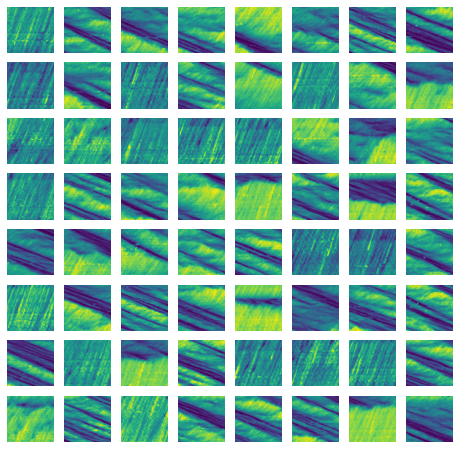

In [3]:
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(data[np.random.randint(data.shape[0])][0].T, origin="lower" )
        ax[i, j].axis("off")

In [4]:
# Normalize the data with min-max scaling

data_min = 0 # data.min()
data_max = data.max()

data = (data - data_min) / (data_max - data_min)

In [5]:
# Split the data into training and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [6]:
available = torch.cuda.is_available()
curr_device = torch.cuda.current_device()
device = torch.device("cuda:0" if available else "cpu")
device_count = torch.cuda.device_count() 

print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')

Cuda available: True
Current device: 0
Device: cuda:0
Device count: 0


In [7]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.utils.weight_norm(nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    ))

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            # norm_layer = nn.BatchNorm2d
            norm_layer = nn.InstanceNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [8]:
class MyBatchNorm2d(nn.modules.batchnorm._NormBase):

    def __init__(
        self,
        num_features,
        eps=1e-5,
        momentum=0.005,
        device=None,
        dtype=None
    ):
        factory_kwargs = {'device': device, 'dtype': dtype, 'affine': False, 'track_running_stats': True}
        super(MyBatchNorm2d, self).__init__(
            num_features, eps, momentum, **factory_kwargs
        )

    def forward(self, input, validation=False):
        if self.training:
            # Note: Need to detatch `running_{mean,var}` so don't backwards propagate through them
            unbiased_var, tmean = torch.var_mean(input, [0, 2, 3], unbiased=True)
            mean = torch.mean(input, [0, 2, 3]) # along channel axis
            unbiased_var = torch.var(input, [0, 2, 3], unbiased=True) # along channel axis
            running_mean = (1.0 - self.momentum) * self.running_mean.detach() + self.momentum * mean
            
            # Strange: PyTorch impl. of running variance uses biased_variance for the batch calc but
            # *unbiased_var* for the running_var!
            # https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/Normalization.cpp#L190
            running_var = (1.0 - self.momentum) * self.running_var.detach() + self.momentum * unbiased_var
            
            # BK: Modification from the paper to use running mean/var instead of batch mean/var
            # change shape
            current_mean = running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = running_var.view([1, self.num_features, 1, 1]).expand_as(input)
            
            denom = (current_var + self.eps)
            y = (input - current_mean) / denom.sqrt()
            
            self.running_mean = running_mean
            self.running_var = running_var
            
            return y, -0.5 * torch.log(denom)
        else:
            current_mean = self.running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = self.running_var.view([1, self.num_features, 1, 1]).expand_as(input)
            
            if validation:
                denom = (current_var + self.eps)
                y = (input - current_mean) / denom.sqrt()
            else:
                # Reverse operation for testing
                denom = (current_var + self.eps)
                y = input * denom.sqrt() + current_mean
                
            return y, -0.5 * torch.log(denom)

def bottleneck_backbone(in_planes, planes):
    return nn.Sequential(
        conv3x3(in_planes, planes),
        nn.InstanceNorm2d(planes),
        BasicBlock(planes, planes),
        BasicBlock(planes, planes),
        conv3x3(planes, in_planes),
        nn.InstanceNorm2d(planes),
    )

check_mask = {}
check_mask_device = {}

def checkerboard_mask(shape, to_device=True):
    global check_mask, check_mask_device
    if shape not in check_mask:
        check_mask[shape] = 1 - np.indices(shape).sum(axis=0) % 2
        check_mask[shape] = torch.Tensor(check_mask[shape])
        
    if to_device and shape not in check_mask_device:
        check_mask_device[shape] = check_mask[shape].to(device)
        
    return check_mask_device[shape] if to_device else check_mask[shape]

chan_mask = {}
chan_mask_device = {}
def channel_mask(shape, to_device=True):
    assert len(shape) == 3, shape
    assert shape[0] % 2 == 0, shape
    global chan_mask, chan_mask_device
    if shape not in chan_mask:
        chan_mask[shape] = torch.cat([torch.zeros((shape[0] // 2, shape[1], shape[2])),
                                      torch.ones((shape[0] // 2, shape[1], shape[2])),],
                                      dim=0)
        assert chan_mask[shape].shape == shape, (chan_mask[shape].shape, shape)
        
    if to_device and shape not in chan_mask_device:
        chan_mask_device[shape] = chan_mask[shape].to(device)
        
    return chan_mask_device[shape] if to_device else chan_mask[shape]

In [9]:
class NormalizingFlow(nn.Module):
    EPSILON = 1e-5
    
    def __init__(self, num_coupling=6, num_final_coupling=4, planes=64):
        super(NormalizingFlow, self).__init__()
        self.num_coupling = num_coupling
        self.num_final_coupling = num_final_coupling
        self.shape = (4, 64, 64)
        
        self.planes = planes
        self.s = nn.ModuleList()
        self.t = nn.ModuleList()
        self.norms = nn.ModuleList()
        
        # Learnable scalar scaling parameters for outputs of S and T
        self.s_scale = nn.ParameterList()
        self.t_scale = nn.ParameterList()
        self.t_bias = nn.ParameterList()
        self.shapes = []
      
        shape = self.shape
        for i in range(num_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            
            self.norms.append(MyBatchNorm2d(shape[0]))
            
            self.shapes.append(shape)
           
            if i % 6 == 2:
                shape = (4 * shape[0], shape[1] // 2, shape[2] // 2)
                
            if i % 6 == 5:
                # Factoring out half the channels
                shape = (shape[0] // 2, shape[1], shape[2])
                planes = 2 * planes
       
        # Final coupling layers checkerboard
        for i in range(num_final_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            
            self.norms.append(MyBatchNorm2d(shape[0]))
            
            self.shapes.append(shape)
           
        self.validation = False
    
    def validate(self):
        self.eval()
        self.validation = True
        
    def train(self, mode=True):
        nn.Module.train(self, mode)
        self.validation = False

    def forward(self, x):
        if self.training or self.validation:
            s_vals = []
            norm_vals = []
            y_vals = []
            
            for i in range(self.num_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
               
                if self.norms[i] is not None:
                    y, norm_loss = self.norms[i](y, validation=self.validation)
                    norm_vals.append(norm_loss)
                    
                if i % 6 == 2:
                    y = torch.nn.functional.pixel_unshuffle(y, 2)
                    
                if i % 6 == 5:
                    factor_channels = y.shape[1] // 2
                    y_vals.append(torch.flatten(y[:, factor_channels:, :, :], 1))
                    y = y[:, :factor_channels, :, :]
                    
                x = y
                
            # Final checkboard coupling
            for i in range(self.num_coupling, self.num_coupling + self.num_final_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
                
                if self.norms[i] is not None:
                    y, norm_loss = self.norms[i](y, validation=self.validation)
                    norm_vals.append(norm_loss)
                
                x = y

            y_vals.append(torch.flatten(y, 1))
            
            # Return outputs and vars needed for determinant
            return (torch.flatten(torch.cat(y_vals, 1), 1),
                    torch.cat(s_vals), 
                    torch.cat([torch.flatten(v) for v in norm_vals]) if len(norm_vals) > 0 else torch.zeros(1),
                    torch.cat([torch.flatten(s) for s in self.s_scale]))
        else:
            y = x
            y_remaining = y
           
            layer_vars = np.prod(self.shapes[-1])
            y = torch.reshape(y_remaining[:, -layer_vars:], (-1,) + self.shapes[-1])
            y_remaining = y_remaining[:, :-layer_vars]
            
            # Reversed final checkboard coupling
            for i in reversed(range(self.num_coupling, self.num_coupling + self.num_final_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
                
                if self.norms[i] is not None:
                    y, _ = self.norms[i](y)
              
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                y = x           
          
            layer_vars = np.prod(shape)
            y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
            y_remaining = y_remaining[:, :-layer_vars]
            
            # Multi-scale coupling layers
            for i in reversed(range(self.num_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
              
                if self.norms[i] is not None:
                    y, _ = self.norms[i](y)
                    
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                if i % 6 == 3:
                    x = torch.nn.functional.pixel_shuffle(x, 2)
                    
                y = x
                
                if i > 0 and i % 6 == 0:
                    layer_vars = np.prod(shape)
                    y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
                    y_remaining = y_remaining[:, :-layer_vars]
            
            assert np.prod(y_remaining.shape) == 0
            
            return x

In [10]:
PI = torch.tensor(np.pi).to(device)
def loss_fn(y, s, norms, scale, batch_size):
    # -log(zero-mean gaussian) + log determinant
    # -log p_x = log(pz(f(x))) + log(det(\partial f/\partial x))
    # -log p_x = 0.5 * y**2 + s1 + s2 + ... + batch_norm_scalers + l2_regularizers(scale)
    logpx = -torch.sum(0.5 * torch.log(2 * PI) + 0.5 * y**2)
    det = torch.sum(s)
    norms = torch.sum(norms)
    reg = 5e-5 * torch.sum(scale ** 2)
    loss = -(logpx + det + norms) + reg
    return torch.div(loss, batch_size), (-logpx, -det, -norms, reg)

In [11]:
def pre_process(x):
    # Convert back to integer values
    x = x * 255.
    
    # Add random uniform [0, 1] noise to get a proper likelihood estimate
    # https://bjlkeng.github.io/posts/a-note-on-using-log-likelihood-for-generative-models/
    x = x + torch.rand(x.shape)

    # Apply transform to deal with boundary effects (see realNVP paper)
    x = torch.logit(0.05 + 0.90 * x / 256)
    return x
    #return x / 255

def post_process(x):
    # Convert back to integer values
    return torch.clip(torch.floor(256 / 0.90 * (torch.sigmoid(x) - 0.05)), min=0, max=255) / 255
    #return torch.clip(x, min=0, max=1)
    
def log_preprocessing_grad(y):
    # Used to adjust for pixel preprocessing
    # log(grad(pre_processing))
    # = log(grad(logit(0.9 / 256 * x + 0.05)))
    
    # Assume input is y = pre_process(x)
    x = 256 / 0.90 * (torch.sigmoid(y) - 0.05)
    arg = 0.9 * x / 256 + 0.05
    return torch.log(1 / arg + 1 / (1 - arg)) + np.log(0.9 / 256)

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size, report_iters=10, num_pixels=64*64*4):
    size = len(dataloader)
    avg_loss = 0
    for batch, X in enumerate(dataloader):
        # Transfer to GPU
        X = pre_process(X)
        X = X.to(device)
        
        # Compute prediction and loss
        y, s, norms, scale = model(X)
        loss, comps = loss_fn(y, s, norms, scale, batch_size)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        loss, current = loss.item(), batch
        # Account for preprocessing
        loss -= torch.sum(log_preprocessing_grad(X)) / batch_size
        avg_loss += loss
        
        if batch % report_iters == 0:
            print(f"loss: {loss:.2f} = -logpx[{comps[0]:.1f}], -det[{comps[1]:.1f}], -norms[{comps[2]:.1f}], reg[{comps[3]:.4f}]"
                  f"; bits/pixel: {loss / num_pixels / np.log(2):>.2f}  [{current:>5d}/{size:>5d}]")
        
    avg_loss = avg_loss / (batch + 1)
    print(f"Train Error: \n Avg loss: {avg_loss:.2f}; {avg_loss / num_pixels / np.log(2):.2f} \n")
    
    return avg_loss / num_pixels / np.log(2)
            
        
def test_loop(dataloader, model, loss_fn, num_pixels=64*64*4):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        model.validate()
        for X in dataloader:
            X = pre_process(X)
            X = X.to(device)
            y, s, norms, scale = model(X)
            loss, _ = loss_fn(y, s, norms, scale, batch_size)
            test_loss += loss
            test_loss -= torch.sum(log_preprocessing_grad(X)) / batch_size
        model.train()

    test_loss /= num_batches
    # Account for preprocessing
    print(f"Test Error: \n Avg loss: {test_loss:.2f}; {test_loss / num_pixels / np.log(2):.2f} \n")
    return test_loss, test_loss / num_pixels / np.log(2)

In [13]:
learning_rate = 0.00075
batch_size = 64
epochs = 15

In [14]:
model = NormalizingFlow(num_coupling=18, num_final_coupling=4, planes=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

PATH = 'checkpoints/'
best_validation = None
best_path = None
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer, batch_size)
    validation_loss, validation_bpp = test_loop(val_loader, model, loss_fn)

    if best_validation is None or validation_bpp < best_validation:
        best_validation = validation_bpp
        best_path = PATH + f'celeba-{t + 1}.model'
        torch.save({
            'epoch': t + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': validation_loss,
        }, PATH + f'celeba-{t + 1}.model')
    scheduler.step()

print("Done - ", best_path, " = ", best_validation)

Epoch 1
-------------------------------
loss: 89448.99 = -logpx[1497042.2], -det[-0.0], -norms[-163.8], reg[0.0000]; bits/pixel: 7.88  [    0/  125]
loss: 87934.66 = -logpx[1392521.6], -det[-4866.7], -norms[-12693.8], reg[0.0002]; bits/pixel: 7.74  [   10/  125]
loss: 87138.35 = -logpx[1421071.0], -det[-9629.4], -norms[-35466.0], reg[0.0008]; bits/pixel: 7.67  [   20/  125]
loss: 85937.42 = -logpx[1360335.6], -det[-20725.3], -norms[-73726.4], reg[0.0020]; bits/pixel: 7.57  [   30/  125]
loss: 85352.52 = -logpx[1361373.0], -det[-19075.7], -norms[-122667.6], reg[0.0036]; bits/pixel: 7.52  [   40/  125]
loss: 83433.97 = -logpx[1305273.0], -det[-35426.7], -norms[-191483.2], reg[0.0056]; bits/pixel: 7.35  [   50/  125]
loss: 83131.56 = -logpx[1363952.5], -det[-29247.1], -norms[-258910.9], reg[0.0082]; bits/pixel: 7.32  [   60/  125]
loss: 81468.79 = -logpx[1342289.2], -det[-36052.0], -norms[-328238.7], reg[0.0111]; bits/pixel: 7.17  [   70/  125]
loss: 80742.73 = -logpx[1345874.5], -det[-22

In [15]:
# DEBUG - Checkmodel[s]
model.validate()
with torch.no_grad():
    for x in train_loader:
        x_pre = pre_process(x).to(device)
        y, s, norms, scale = model(x_pre)
        print(y.shape)
        break

model.train()
model.eval()
with torch.no_grad():
    xp = model(y)
    x_post = post_process(xp)

diff = x.to(device) - x_post
print(torch.any(torch.abs(diff) > 1 / 255))

torch.Size([64, 16384])
tensor(True, device='cuda:0')


In [16]:
print(diff.shape)
for i in range(batch_size):
    if torch.any(torch.abs(diff[i]) > 1 / 255):
        #print(diff[i])
        for j in range(28):
            for k in range(28):
                if torch.any(torch.abs(diff[i, 0, j, k]) > 1 / 255):
                    print(i, 1, j, k, diff[i, 0, j, k].cpu().numpy())
                    break
        break

torch.Size([64, 4, 64, 64])


count    1.048576e+06
mean    -1.912086e-02
std      9.859156e-01
min     -8.077390e+00
25%     -6.426265e-01
50%     -2.083104e-02
75%      6.016870e-01
max      1.105509e+01
dtype: float64


<AxesSubplot:>

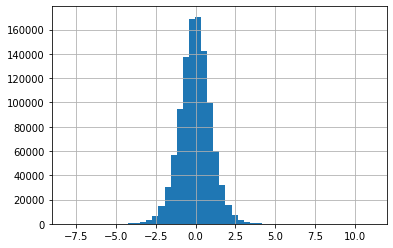

In [17]:
import pandas as pd

s = pd.Series(torch.flatten(y).cpu().numpy())
print(s.describe())
s.hist(bins=50)

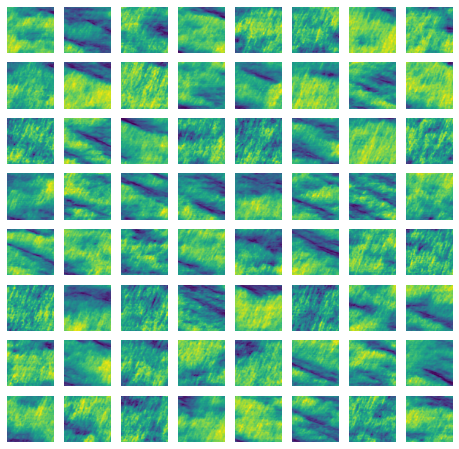

In [19]:
cols, rows = 8, 8

with torch.no_grad():
    X = torch.Tensor(torch.normal(torch.zeros(cols * rows, 64 * 64 * 4),
                                  torch.ones(cols * rows, 64 * 64 * 4))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu()

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i * 8 + j][0,:,:].T, origin="lower")
        ax[i, j].axis("off")
plt.show()